# IQFT with Amplitude encoding (not working) 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [45]:
n = 8
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(1, 7)
radius = 1 

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-1.8089464e-02+8.0179190e-03j  1.1102204e-02+1.4560439e-02j
  -8.0734091e-03-4.3995408e-03j  2.7567465e-03-7.0150761e-04j
   1.0397654e-02-5.4847575e-03j  1.5837137e-02+1.3075963e-02j
   1.0775845e-02+7.6452671e-03j  2.9341045e-03+2.0557579e-02j]
 [-6.7749517e-03-2.0255020e-02j -4.4412864e-03+3.7863688e-03j
   1.1565757e-03-3.8192114e-03j  1.7072290e-02-1.1285861e-03j
   8.0575179e-03+6.3598449e-03j  1.1573814e-02+1.1916915e-02j
   2.7777685e-03+8.5563548e-03j -5.0978237e-03+1.3251106e-02j]
 [-1.5595671e-03+1.7320807e-04j -9.4732754e-03-2.3889272e-02j
  -1.5002996e-02-1.1934279e-03j  2.0873791e-02-8.4304949e-03j
  -8.8328792e-04-2.7925512e-03j -9.2026209e-03-3.3361674e-03j
  -6.9249962e-03-9.9723646e-03j  9.9364696e-03+9.7336154e-04j]
 [ 9.6978825e-03-1.4852242e-02j -9.9422503e-03-5.6820503e-03j
  -3.6151253e-03-2.8352244e-03j  1.3706073e-02-8.9626946e-03j
  -1.2740237e-02-2.1964431e-02j -5.7492647e-03-5.5639469e-03j
  -1.7822211e-03+4.6812082e-03j  1.1346488e-02-9.6688624e-03j]
 [ 5

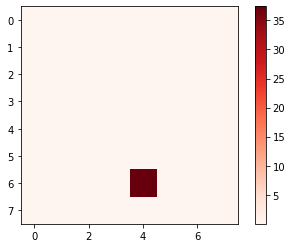

In [46]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [47]:
visibilities = np.fft.fft(sky_image.flatten()).astype('complex64')
print(visibilities)

[ 37.104973  +4.667912j    9.839426 +36.17641j   -29.498419 +22.78792j
 -32.460423 -18.68928j     4.833688 -37.03493j    36.086975  -9.661635j
  22.930044 +29.541676j  -18.6288   +32.454033j  -37.3025    -4.6844964j
  -9.875469 -35.924606j   29.613043 -22.67778j    32.508    +18.63209j
  -4.8844504+37.16661j   -36.090115  +9.7684355j -22.791378 -29.696941j
  18.625113 -32.524807j   37.109543  +4.8560715j   9.791055 +36.075687j
 -29.72377  +22.878496j  -32.5181   -18.669128j    4.827942 -37.146904j
  36.129154  -9.765064j   22.871168 +29.706516j  -18.670822 +32.410187j
 -37.1399    -4.8351274j  -9.882513 -36.163307j   29.574635 -22.780571j
  32.357475 +18.587973j   -4.8814187+37.203068j  -36.169415  +9.719986j
 -22.881617 -29.787622j   18.77571  -32.619373j   36.982033  +4.8335567j
   9.651513 +36.030872j  -29.706652 +22.8062j    -32.601288 -18.70668j
   4.77394  -37.057774j   36.1       -9.864953j   22.917553 +29.525682j
 -18.633358 +32.548557j  -37.028355  -4.773066j   -9.798989 -36.2

In [48]:
sanity = np.fft.ifft(visibilities).astype('complex64')
sanity = np.array(sanity).reshape(sky_image.shape[0] , sky_image.shape[1])

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 1.0026097e-14
Imaginaries MSE: 8.880663e-15


Wires: range(0, 6)


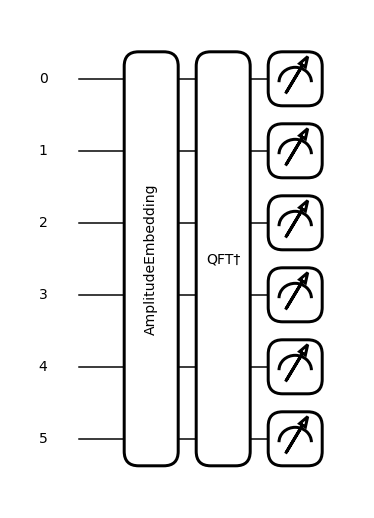

In [63]:
n_n = n*n
inp = visibilities

norm = qml.math.sum(qml.math.abs(inp) ** 2)
#normalized_data = data / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n_n)))
print( 'Wires: ' + str(wires) )
amp_dev = qml.device('default.qubit', wires)


@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
    qml.adjoint(qml.QFT)(wires=wires)
    return qml.state()

readout = amp_encoding(inp).astype('complex64')
qml.draw_mpl(amp_encoding)(inp)

readout.numpy()
readout = readout*qml.math.sqrt(norm)
readout.real = readout.real/2**64
readout = readout[:n_n]
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])

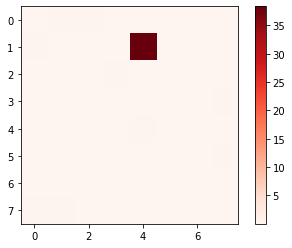

In [64]:
modulus = np.absolute(readout)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

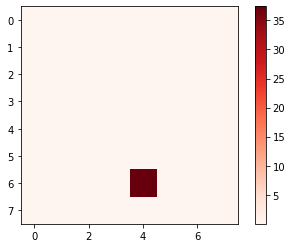

In [65]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [66]:
fidelity = readout

test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 21.520742
Imaginaries MSE: 23.348022


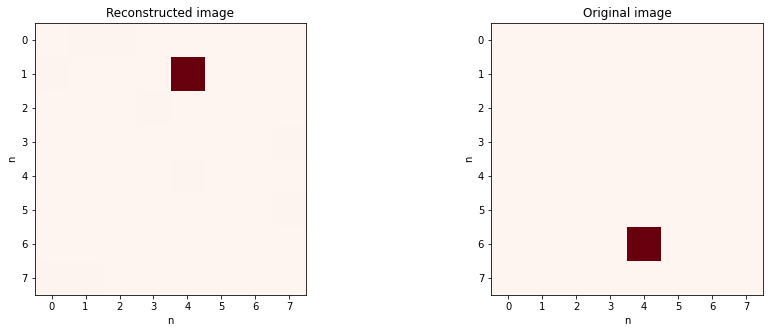

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(fidelity)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')